<a href="https://colab.research.google.com/github/n-vit/YaP_Projects/blob/main/data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

**Содержание датафрейма** (информация от заказчика):

**children** — количество детей в семье

**days_employed** — общий трудовой стаж в днях

**dob_years** — возраст клиента в годах

**education** — уровень образования клиента

**education_id** — идентификатор уровня образования

**family_status** — семейное положение

**family_status_id** — идентификатор семейного положения

**gender** — пол клиента

**income_type** — тип занятости

**debt** — имел ли задолженность по возврату кредитов

**total_income** — ежемесячный доход

**purpose** — цель получения кредита

<div class="alert alert-success">
    
<b> Комментарий от ревьюера ✔️</b>
    
Здорово, что добавил описание данных!
</div>


## Шаг 1. Откройте файл с данными и изучите общую информацию

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
from pymystem3 import Mystem
m = Mystem()
from collections import Counter

data = pd.read_csv('/datasets/data.csv')

data.info()
#data.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [ ]:
data.head(5)
# отрицательные данные в стаже работы
# разные регистры в образовании
# свободный текст в цели кредита


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [ ]:
data.loc[data.loc[:, 'days_employed'] < 0]['days_employed'].count() #количество отрицательных значений в стаже

15906

75% данных о стаже имеют отрицательные значения. Посмотрим как данные посеяны относительно возраста

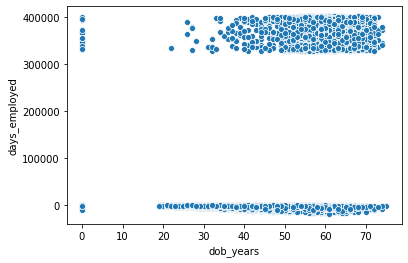

In [ ]:
sns.scatterplot(data=data, x="dob_years", y="days_employed")

In [ ]:
data.loc[data.loc[:, 'days_employed'] < 0]['days_employed'].min()/-365 #максимальный стаж (лет)

50.38068465909146

Явно выделяются две группы данных о стаже работы - меньше нуля, и больше 300 тысяч. И то и другое - ошибки. 

В отрицательной группе значения меняются пропорционально возрасту от нуля до 50 лет, выглядит логично, похоже данные корректные, но нужно привести их к положительным значениям. 

С аномально большими данными все сложнее - количество записей растет с возрастом, но явной зависимости данных от возраста не вижу. Эти данные составляют 25% от выборки. Их заменим медианными значениями по возрасту из корректной выборки. 



Попробуем так: сравним медианы модуля отрицательных значений стажа и резко-положительных, и поищем логику:


In [ ]:
print(data.query('days_employed > 0')['days_employed'].median()/365)
print(abs(data.query('days_employed < 0')['days_employed'].median()/365))

1000.5844007280306
4.465806523226909


<div class="alert alert-info">  
Медианный стаж у наших заемщиков 4.5 года (по отрицательным значениям). А в "странных" данных - 1000. 
    
Съехавшую запятую пока отметаем, тогда менялся бы только порядок. Остался вопрос в единицах. часы? минуты? секунды?
</div>

In [ ]:
what_is_it = data.query('days_employed > 0')['days_employed'].median()/365
print('если завышенные данные не в днях, а в часах, то медиана стажа будет', what_is_it / 24, 'лет')
print('если завышенные данные не в днях, а в часах, то медиана стажа будет', what_is_it / 24 / 60, 'лет')
print('если завышенные данные не в днях, а в часах, то медиана стажа будет', what_is_it /24 /60 /60, 'лет')

если завышенные данные не в днях, а в часах, то медиана стажа будет 41.691016697001274 лет
если завышенные данные не в днях, а в часах, то медиана стажа будет 0.6948502782833545 лет
если завышенные данные не в днях, а в часах, то медиана стажа будет 0.011580837971389242 лет


<div class="alert alert-info">  
В часах, но в десять раз больше? - т.е. и единицы, да еще и точка съехала?
</div>

In [ ]:
big_data = data.query('days_employed > 0')['days_employed']/240/365
negative_data = abs(data.query('days_employed < 0')['days_employed'])/365

print(big_data.describe())
print()
print(negative_data.describe())

count    3445.000000
mean        4.166716
std         0.240582
min         3.752611
25%         3.957071
50%         4.169102
75%         4.374959
max         4.586249
Name: days_employed, dtype: float64

count    15906.000000
mean         6.446619
std          6.312997
min          0.066141
25%          2.072252
50%          4.465807
75%          8.650630
max         50.380685
Name: days_employed, dtype: float64


In [ ]:
data.query('days_employed > 0')['days_employed'].corr(data.query('days_employed > 0')['dob_years'])

0.021300206964462685

<div class="alert alert-info">  
И все-же нет. Нижний дескрипт похож на правду - стаж от нуля до 50 лет, логичные среднее и медиана, хорошая выборка, им можно пользоваться 
    
Верхний - Строки, которые вообще не коррелируют с возрастом и не похожи на стаж. Если нет никакой информации о возможных источниках ошибки - выйдет гадание на кофейной гуще. 
    
Думаю изначально был выбран верный способ восстановления данных  о стаже - на основе медианного значения стажа для выбранного возраста. 
</div>

In [ ]:

data['children'].value_counts()

# отрицательные и аномально высокие значения в количестве детей 

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

76 записей где 20 детей. Похоже что тут лишний нолик. Бывают конечно многодетные семьи, но чтобы так кучно попасть в 20 - вряд-ли. Случайный минус тоже переведем в плюс. 

In [ ]:
data.duplicated().sum()

54

В данных 54 явных дубликата, но это не все. Посмотрим на уникальные данные в столбцах object: в данных об образовании есть неявные дубликаты из-за разного регистра. А для данных о причине кредита требуется лемматизация. 

In [ ]:
data['education'].unique()

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

**Вывод**

В датасете 21 525 строк, названия столбцов корректные. Сет содержит ошибки:
- _children_ содержит отрицательные (-1) и аномально высокие (20) значения. Ошибки записи - лишний ноль и знак "-". Исправим

- _days_employed_ содержит данные float, в т.ч. отрицательные значения, которые можно будет привести к модулю. Средний стаж работы растет пропорционально возрасту, но очевидно содержит общую ошибку, т.к. значения стажа превышают значения возраста. Содержит пропуски (10% от сета), которые могут быть заполнены на основании данных о возрасте и типе занятости

- _dob_years_ содержит возрасты от 19 до 75 лет, и пропуски (нулевые значения), которые могут быть заполнены на основании данных о стаже

- _education_ содержит одинаковые записи в разных регистрах, нужно привести к единой форме записи

- _education_ и _family_status_ корректно дублируются id в целых числах 

- _income_type_ - содержит технически корректные object типы занятости 

- _total_income_  содержит пропуски в данных (10% сета), которые могут быть заполнены на основании данных о типе занятости

- _debt_ содержат int значения 1 и 0, заполнены технически корректно. 

- _purpose_ содержит свободные текстовые конструкции, по которым можно провести леммитизацию для дальнейшего анализа

Cет содержит 54 явных дубликата, но их число может увеличиться после приведения данных об образовании к единому регистру и исправлении ошибок ввода в информации о детях. 


**Для проведения анализа нужно провести предобработку**


## Шаг 2. Предобработка данных

### Обработка пропусков
**Стаж работы**

Сначала разберемся с самым ошибочным столбцом - стажем работы, в котором содержатся:

- завышенные данные неизвестной природы, не коррелирующие с возрастом (вероятно ошибка обработки)
- отрицательные значения модуль которых соответствует стажу и пропорционален возрасту (ошибка заполнения данных)
- 10% пропущенной информации. 

Нужно учитывать что есть заполненные значения стажа для нулевого возраста (ошибка возраста), и есть значения возраста для которых нет корректных данных о стаже (ошибка стажа).  

Восстановим данные стажа так:
1. Выделим отрицательные данные стажа в отдельный столбец из которого будем брать медианные значения для заполнения, чтобы масса положительных ошибок не влияла на результат
2. Заменим все ошибки на корректные данные:
- для отрицательных значений восстановим модуль
- для завышенных - медианы из нового столбца по соответствующему возрасту
- если возраст 0 или для него нет корректных данных - возьмем медианное значение стажа по всей выборке.
3. Приведем стаж к целым числам (дням), и удалим вспомогательный столбец

In [ ]:
data['true_days'] = data.loc[data.loc[:, 'days_employed'] < 0]['days_employed'] 

In [ ]:
def days_recovery(row): #функция принимает строку датафрейма и возвращает медиану стажа
    age = row['dob_years']
    expirience = row['days_employed']
    recovered = 0
        
    # Если стаж отрицательный - возвращаем в ячейку его модуль
    if expirience < 0:
        recovered = abs(expirience)
        
    # Если стаж больше нуля и есть отрицательная медиана значений стажа для выбранного года, то возвращаем ее в ячейку
    elif data.query('dob_years == @age')['true_days'].median() < 0: 
        recovered = abs(data.query('dob_years == @age')['true_days'].median())
        
    # В остальных случаях, если нет отрицательных значений для года, или вообще нет значений - возвращаем медиану общего стажа
    else:
        recovered = abs(data['true_days'].median())
    return recovered    

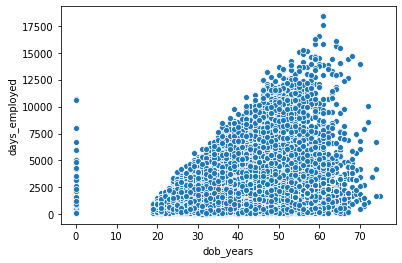

In [ ]:
data['days_employed'] = data.apply(days_recovery, axis= 1)
sns.scatterplot(data=data, x="dob_years", y="days_employed")

<div class="alert alert-info">  
Действительно с функцией стало быстрее, спасибо! 
</div>

In [ ]:
data['days_employed'] = data['days_employed'].astype(int)
data = data.drop(axis=1, columns='true_days')

Данные по стажу работы готовы к дальнейшему анализу. 

**Возраст**

Возраст и стаж имеют линейную зависимость,  можно восстановить пропущенные значения возраста через отношение среднего стажа к среднему возрасту в выборке.
Если расчетное значение возраста меньше минимального (19) или больше максмального (75) в выборке, то вернем минимум или максимум. Для остальных пропусков в возрасте оставим расчетное значение для указанного стажа. 

<div class="alert alert-info">
    
В заполнении пропусков возраста цикл тоже заменил на функцию
    
</div>

In [ ]:
def age_recovery(row): #функция принимает строку и возвращает возраст в диапазоне от 19 до 75
    age = row['dob_years']
    expirience = row['days_employed']
    index_expirience = data['days_employed'].mean() / data['dob_years'].mean() # коэф-т зависимости стажа и возраста
    if age == 0:
        if expirience / index_expirience < 19:
            age = 19
        elif expirience / index_expirience > 75:
            age = 75
        else:
            age = expirience / index_expirience    
    return age

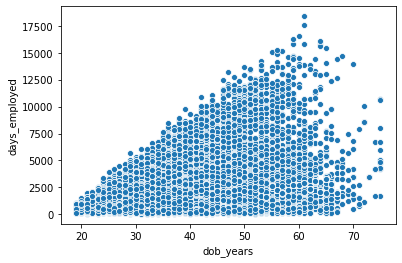

In [ ]:
data['dob_years'] = data.apply(age_recovery, axis= 1) # закомментированный код заменен на функцию 
'''for index in range(len(data['dob_years'])):
    index_expirience = data['days_employed'].mean() / data['dob_years'].mean() #коэф-т отношения стажа к возрасту
    if data.loc[index, 'dob_years'] == 0:
        if (data.loc[index,'days_employed'] / index_expirience) < 19:
            data.loc[index,'dob_years'] = 19
        elif (data.loc[index,'days_employed'] / index_expirience) >75:
            data.loc[index,'dob_years'] = 75
        else:
            data.loc[index,'dob_years'] = (data.loc[index,'days_employed'] / index_expirience)
data['dob_years'] = data['dob_years'].astype(int) '''  
sns.scatterplot(data=data, x="dob_years", y="days_employed")

Возраст и стаж в порядке. 

**Дети**

В столбце о количестве детей заменим отрицательные значения на модули, а ячейки с количеством детей 20 (их 76), на значение 2. Очевидно, что ноль лишний при заполнении или обработке, т.к. если бы речь шла об аномально многодетных семьях - в массиве были бы близкие значения. 

In [ ]:
data.loc[data.children == 20, 'children'] = 2
data.children = data.children.abs()
data['children'].unique()

array([1, 0, 3, 2, 4, 5])

C детьми теперь тоже все в порядке. Остались критичные пропуски в информации о доходах. 

**Доход**

Доход больше всего зависит от образования и типа занятости. Это легко проверить меняя значения Х в scatterplote, если по оси Y - данные о доходах. Пропущенные значения можно восстановить медианой выборки по этим значениям. 

логичное решение - перебрать строки, и если ячейка данных о доходе NaN - заменить ее на медиану по выбранному типу дохода. Но функция isna() не работает с конкретной ячейкой и получить индекс нужной строки для указания типа дохода не выходит. 

Если заменить NaN на любое числовое значение - перебор строк будет работать, но новое значение будет влиять на расчет медианы. 

Поэтому:
1) выделим исходные данные о доходах в отдельный столбец 'for_income'

2) заменим в столбце 'total_income' значением 0, предварительно проверив что оно свободно 

3) проведем перебор строк, и для тех, в которых total_income = 0, поставим в нулевые ячейки медиану, рассчитанную на чистых значениях из столбца for_income, а потом удалим вспомогательный столбец. 

_Чувствую что это какой-то костыль, и должно быть более элегантное решение в пару строк, но пока найти его не удалось, а дедлайн вот он._ 




In [ ]:
data['total_income'] = data.groupby(['income_type', 'education_id'])['total_income'].transform(lambda x: x.fillna(x.mean()))
data['total_income'].describe()

count    2.152500e+04
mean     1.674413e+05
std      9.812909e+04
min      2.066726e+04
25%      1.077982e+05
50%      1.525055e+05
75%      1.981493e+05
max      2.265604e+06
Name: total_income, dtype: float64

**Вывод**

В исходных данных были ошибки записи и технические ошибки, которые были исправлены путем восстановления данных 

Для пропусков стажа данные восстановлены на основе информации о возрасте,

Для нулевого возраста - из данных о стаже

Для пропусков в данных о доходе восстановлен медианный доход для указанного типа дохода и образования.

Пропуски в данных о стаже и доходах составляли 10% от выборки и это нужно учитывать в дальнейших выводах. 


### Замена типа данных

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       21525 non-null int64
dob_years           21525 non-null float64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        21525 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


**Вывод**

Мы привели данные к нужным типам в процессе заполнения пропусков:
Данные о стаже в днях были дробными - они методом astype() переведены в целые числа -учитываются только полные дни, дробная часть отсекается. 
Можно идти дальше. 

### Обработка дубликатов

Чтобы удалить все дубликаты, приведем записи в данных об образовании к единому регистру, посмотрим на количество дубликатов (интересно же), и удалим полностью повторяющиеся строки

In [ ]:
data['education'] = data['education'].str.lower()
data.duplicated().sum()

71

In [ ]:
data = data.drop_duplicates().reset_index(drop=True)
data.duplicated().sum()

0

**Вывод**

Полностью повторяющиеся строки - скорее всего ошибки обработки данных. И хотя в сете нет уникальных идентификаторов - вероятность повторения всех параметров для разных клиентов очень мала. 
После обработки сведений об образовании число дубликатов действительно увеличилось с 54 до 71, т.к. функция duplicated() учитывает регистр в котором записаны значения. Дубликаты удалены, сет готов к дальнейшей работе. 

<div class="alert alert-success">
    
<b> Комментарий от ревьюера ✔️</b>
    
С обработкой явных и неявных дубликатов все отлично
</div>

### Лемматизация

In [ ]:
lemma = data['purpose'] # сначала сохраним исходный столбец в переменную, чтобы использовать ее в счетчике слов

In [ ]:
lemma = ' '.join(lemma)
Counter(m.lemmatize(lemma)) #выведем лемматизированный счетчик чтобы собрать словарь

Counter({'покупка': 5897,
         ' ': 55023,
         'жилье': 4460,
         'приобретение': 461,
         'автомобиль': 4306,
         'дополнительный': 906,
         'образование': 4013,
         'сыграть': 765,
         'свадьба': 2324,
         'операция': 2604,
         'с': 2918,
         'на': 2222,
         'проведение': 768,
         'для': 1289,
         'семья': 638,
         'недвижимость': 6351,
         'коммерческий': 1311,
         'жилой': 1230,
         'строительство': 1878,
         'собственный': 635,
         'подержать': 853,
         'свой': 2230,
         'со': 627,
         'заниматься': 904,
         'сделка': 941,
         'получение': 1314,
         'высокий': 1374,
         'подержанный': 111,
         'профильный': 436,
         'сдача': 651,
         'ремонт': 607,
         '\n': 1})

In [ ]:
data['purpose'] = data['purpose'].apply(m.lemmatize) # и лемматизируем весь столбец для дальнейшей работы
data.head(5)

NameError: ignored

**Вывод**

Данные лемматизированы. Поскольку лемматизация работает только со строками, чтобы лемматизировать столбец датафрейма применен метод apply, который позволяет применять функцию последовательно для каждого значения в датафрейме. 

Я выделил исходные данные в отдельную переменную, чтобы склеить их, и посчитать количество лемматизированных слов - так проще составить "словарь" для дальнейшей категоризации: выделить основные цели - недвижимость, автомобиль, образование, свадьба.

Уникальных слов оказалось не так много, поэтому данные из каунтера можно обработать вручную. 

<div class="alert alert-success">
    
<b> Комментарий от ревьюера ✔️</b>
    
Ты правильно нашел основные категории кредитов
</div>

### Категоризация данных

Заказчик указал параметры, по которым необходимо провести анализ: наличие детей, семейное положение, уровень дохода и цель кредита. 

Цель кредита и уровень дохода представлены множеством разрозненных значений. В них нужно выделить категории - это упростит анализ. 

**Цель кредита**

Для цели кредита возьмем словарь добытый при лемматизации:

In [ ]:
def lemma_group(row):
    lemma = row['purpose']
    if 'свадьба' in lemma:
        lemma = 'свадьба'
    elif ('недвижимость' in lemma) or ('жилье' in lemma):
        lemma = 'недвижимость'
    elif 'автомобиль' in lemma:
        lemma = 'автомобиль'
    elif 'образование' in lemma:
        lemma = 'образование'
    return lemma


In [ ]:
data['purpose'] = data.apply(lemma_group, axis= 1)
data['purpose'].unique() #проверим уникальные значения в столбце purpose после категоризации


array(['недвижимость', 'автомобиль', 'образование', 'свадьба'],
      dtype=object)

Поделили причины получения кредита на четыре категории, и задали каждой категории id. Теперь их можно анализировать, но сначала нужно категоризировать оставшийся критерий - доход. 

**Доход**

Выделим четыре категории дохода следующим образом:
Средний класс составляет медианный доход +- 30%. 
Доход меньше половины от медианного будем считать низким
Людей с доходом выше трех медиан будем считать богатыми. 

Группа 0 - доходы менее 70% от медианы доходов выборки: низкий доход

Группа 1 от 0,7  до 1,3 медианы выборки: средний класс. 

Группа 2 более 1,3 медианы выборки: высокий доход

Группа 4 более 3 медианных доходов: богатые

In [ ]:
data['income_id'] = ''
def income_group(row): #принимает строку и возвращает в ячейку информацию о группе дохода
    income = row['total_income']
    rank = data['total_income'].median()
    group = row['income_id']
    if income < rank * 1.3:
        if income < rank * 0.7:
            group = 'низкий доход'
        else:
            group = 'средний класс'         
    elif income < rank * 3:
        group = 'высокий доход'
    else:
        group = 'богатые'   
    return group

In [ ]:
data['income_id'] = data.apply(income_group, axis= 1)
data['income_id'].unique()

array(['высокий доход', 'средний класс', 'низкий доход', 'богатые'],
      dtype=object)

**Вывод**

Все данные, в датафрейме, по которым нужно установить зависимость с возвратом кредита в срок -  категоризированы, теперь их можно исследовать и ответить на вопросы заказчика. 


## Шаг 3. Ответьте на вопросы

- **Есть ли зависимость между наличием детей и возвратом кредита в срок?**

Чтобы ответить на этот вопрос - построим сводную таблицу для показателя children, в которой расчитаем долю "плохих" возвратов - отношение суммы значений debt к количеству строк с нужным количеством детей. Чем выше доля "плохих" возвратов, тем выше вероятность просрочки у клиентов выбранного типа:

In [ ]:
children_debt = data.pivot_table(index=['children'], 
                              values='debt', 
                              aggfunc=['sum', 'count', 'mean'])
display(children_debt)

,sum,count,mean
,debt,debt,debt
children,,,
0,1063,14091,0.075438
1,445,4855,0.091658
2,202,2128,0.094925
3,27,330,0.081818
4,4,41,0.097561
5,0,9,0.000000


**Вывод**

Наличие детей отрицательно влияет на возврат кредита в срок - у бездетных клиентов доля плохих возвратов самая низкая. 
А вот количество детей почти не оказывает влияния.

Семей с количеством детей 4 и 5 - мало в выборке, поэтому на результатах средних возвратов в этих группах нельзя основывать выводы

- **Есть ли зависимость между семейным положением и возвратом кредита в срок?**

In [ ]:
family_status_debt = data.pivot_table(index=['family_status'], 
                              values='debt', 
                              aggfunc=['sum', 'count', 'mean'])
display(family_status_debt)

,sum,count,mean
,debt,debt,debt
family_status,,,
Не женат / не замужем,274,2810,0.097509
в разводе,85,1195,0.071130
вдовец / вдова,63,959,0.065693
гражданский брак,388,4151,0.093471
женат / замужем,931,12339,0.075452


**Вывод**

Лучшие заемщики с точки зрения семейного статуса - вдовцы. Люди, находящиеся в браке в среднем возвращают кредиты так же дисциплинировано, как и те что в разводе. 

А клиенты в статусе Не женат / не замужем или в гражданском браке - самые рисковые заемщики. Хотя есть вероятность что тут влияние имеет не семейный статус, а возраст респондентов. Проверим?

**Новая гипотеза - молодежь хуже возвращает кредиты чем люди старшего поколения.**

<div class="alert alert-info">
    
тут еще одна функция вместо цикла
    
</div>

In [ ]:
data['age_group'] = ''
def age_cat(row):
    age = row['dob_years']
    age_group = row['age_group']
    if age < 30:
        age_group = 'молодежь'
    elif age > 55:
        age_group = 'пожилые'
    else:
        age_group = 'средний возраст'
    return age_group

data['age_group'] = data.apply(age_cat, axis= 1)    

age_group_debt = data.pivot_table(index=['family_status', 'age_group'], 
                              values='debt', 
                              aggfunc=['sum', 'count', 'mean'])

display(age_group_debt)

sum count      mean
                                      debt  debt      debt
family_status         age_group                           
Не женат / не замужем молодежь         104   929  0.111948
                      пожилые           16   405  0.039506
                      средний возраст  154  1476  0.104336
в разводе             молодежь          14   101  0.138614
                      пожилые           16   264  0.060606
                      средний возраст   55   830  0.066265
вдовец / вдова        молодежь           1     7  0.142857
                      пожилые           39   602  0.064784
                      средний возраст   23   350  0.065714
гражданский брак      молодежь          70   698  0.100287
                      пожилые           43   705  0.060993
                      средний возраст  275  2748  0.100073
женат / замужем       молодежь         165  1513  0.109055
                      пожилые          127  2377  0.053429
                      средний возраст  639  8449  0.075630

Гипотеза не может быть отклонена отчасти. Люди до 30 действительно хуже остальных возрастных групп дружат с финансами, и чаще допускают просрочки по кредитам (в два раза чаще чем пожилые, причем независимо от семейного статуса). 

Но верно так же и то, что люди незарегистрировавшие свои семейные отношения среднем возрасте так же менее надежные заемщики.

Дисциплинированнее всех выплачивают кредиты пожилые люди с семейным статусом "Не женат / не замужем"

- **Есть ли зависимость между уровнем дохода и возвратом кредита в срок?**


Мы распределили данные на четыре группы по уровню дохода, проверим уровень "плохих" возвратов в каждой группе

In [ ]:
income_debt = data.pivot_table(index=['income_id'], 
                              values='debt', 
                              aggfunc=['sum', 'count', 'mean'])

display(income_debt)

,sum,count,mean
,debt,debt,debt
income_id,,,
богатые,18,315,0.057143
высокий доход,357,5070,0.070414
низкий доход,413,5264,0.078457
средний класс,953,10805,0.088200


**Вывод**

Богатые и бедные в целом платят по кредитам аккуратнее чем средний класс, но разницу нельзя назвать значительной, потому что выборка богатых относительно невелика, а разница в "плохих" возвратах между низким и высоким доходом составляет тысячные доли. 

- **Как разные цели кредита влияют на его возврат в срок?**

In [ ]:
purpose_debt = data.pivot_table(index=['purpose'], 
                              values='debt', 
                              aggfunc=['sum', 'count', 'mean'])
display(purpose_debt)

,sum,count,mean
,debt,debt,debt
purpose,,,
автомобиль,403,4306,0.093590
недвижимость,782,10811,0.072334
образование,370,4013,0.092200
свадьба,186,2324,0.080034


**Вывод**

самые надежные для банка кредитные цели недвижимость и (неожиданно) свадьба. А те кто берет кредит на образование или автомобиль чаще попадают в список debt 

## Шаг 4. Общий вывод

Мы сформировали перечень коэффициентов, которые можно использовать в системе скоринга заказчика. 

Наибольшее доверие вызывают коэффициенты основанные на возрасте заемщиков, семейном положении, наличии детей. Так же стоит обратить внимание на результаты влияния возраста заемщиков - этого запроса не было в задаче, но гипотеза о его влиянии на возвраты подтвердилась. 

Данные о доходе и трудовом стаже изначально содержали большой объем (10%) пропущенных значений. Исследование не подтвердило зависимость между доходом заемщика и аккуратностью возврата. 

Данные можно исследовать глубже:
1. Выделить подкатегории в целях кредита:
- автомобиль (новый / подержанный), 
- образование (высшее, дополнительное), 
- недвижимость (жилую/коммерческую).

2. Влияние сочетаний параметров, например:
- возраст заемщика + цель кредита 
- наличие детей + доходы и т.п. 
В этом случае можем получить более точные прогнозы возврата, но хорошо бы иметь выборку побольше, т.к. часть сочетаний в этой выборке - нерепрезентативна. 



